<a href="https://colab.research.google.com/github/Mobad225/Image-Panoramas/blob/Mobad/Panorama%20Image%20Creator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

# Uploading the images and unzipping them.

In [2]:
os.chdir('/content')
from google.colab import files
files.upload();

Saving pics.zip to pics.zip


In [0]:
!unzip -q pics.zip -d Q1_Pics

# Loading up the images into img1 & img2

In [0]:
os.chdir('/content')
path = '/Q1_Pics/'
os.chdir(os.getcwd() + path)
img1 = cv2.cvtColor(cv2.imread(os.getcwd() + '/left.jpg'), cv2.COLOR_BGR2RGB);
img2 = cv2.cvtColor(cv2.imread(os.getcwd() + '/right.jpg'), cv2.COLOR_BGR2RGB);

# Function to print photos

In [0]:
def print_photo(data_to_show, c_style = None, single = True, title = None,
                true_size = False, pts = []):
  if true_size == True:
    #USER SCREEN DPI
    dpi, dims = 118, data_to_show.shape
    dims_inch = (dims[1]/dpi, dims[0]/dpi)
    plt.figure(figsize=dims_inch)
  plt.axis('off')
  plt.title(title)
  if len(pts) > 0:
    plt.scatter(pts[:,0], pts[:,1], color = 'b')
  if single:
    plt.imshow(data_to_show, cmap = plt.get_cmap(c_style))
    plt.show()
    plt.close()
    print()
    return
  else:
    for curr_img in data_to_show:
      plt.axis('off')
      plt.imshow(curr_img, cmap = plt.get_cmap(c_style))
      plt.show()
      plt.close()
      print()
    return

# Input Images

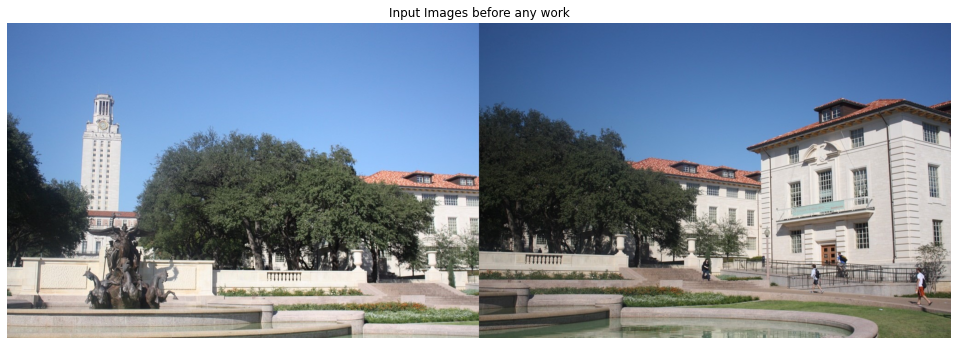

In [123]:
input_imgs = np.concatenate((img1, img2), axis = 1)
print_photo(input_imgs, true_size = True, title = 'Input Images before any work')

# Resize the images

In [0]:
"""
dim = img21.shape
new_dims = (dim[1]//3, dim[0]//3)
img21 = cv2.resize(img21, new_dims, interpolation = cv2.INTER_AREA)
img22 = cv2.resize(img22, new_dims, interpolation = cv2.INTER_AREA)
""";

# Coordinates I chose from both photos

In [0]:
sims_1 = np.array([(995, 901, 810, 760, 599, 965, 562, 1000, 924, 814, 957),
                   (342, 339, 322, 495, 550, 423, 626, 350, 530, 321, 393)]).T
sims_2 = np.array([(540, 458, 369, 308, 139, 506, 87, 544, 461, 372, 501),
                   (325, 315, 293, 461, 513, 401, 595, 334, 500, 292, 372)]).T

# Changing to Homogenous Coordinates

In [0]:
new_axis = np.ones((len(sims_1),1))
hom1 = np.append(sims_1, new_axis, axis = 1)
hom2 = np.append(sims_2, new_axis, axis = 1)

# Constructing the point matrices

In [0]:
no_pts = len(hom1)
P = np.zeros((2 * no_pts, 9))
for i in range(len(P)):
  curr_pt1, curr_pt2 = hom1[i//2], hom2[i//2]
  if i & 1 == 0:
    P[i] = np.append(np.append(curr_pt2 * -1, [0, 0, 0]), curr_pt2 * curr_pt1[0])
  else:
    P[i] = np.append(np.append([0, 0, 0], curr_pt2 * -1), curr_pt2 * curr_pt1[1])

# Singular Value decomposition $PH = 0$ 

In [275]:
u, s, vh = np.linalg.svd(P)
H = vh[-1:].T
H = H / H[8]
H = np.reshape(H, (3,3))
print('Homography Matrix'.center(50) , H, sep = '\n')

                Homography Matrix                 
[[ 6.57347523e-01 -1.28269057e-02  4.65021724e+02]
 [-1.62643615e-01  8.27178581e-01  9.86858881e+01]
 [-2.76496447e-04 -9.56174795e-05  1.00000000e+00]]


# Checking correct Homography mapping.

### $P^{*} = H * P$

In [268]:
res = H.dot(hom2.T).T
for i in range(len(res)):
  res[i][0] = res[i][0] / res[i][2]
  res[i][1] = res[i][1] / res[i][2]
res = res[:,:2]
for i in range(len(res)):
  print(np.round(res[i]).astype(int) , '\tShould be   -->\t' , sims_1[i])
print('\nMy comment : Results are pretty accurate')

[995 341] 	Should be   -->	 [995 342]
[904 338] 	Should be   -->	 [901 339]
[809 323] 	Should be   -->	 [810 322]
[760 494] 	Should be   -->	 [760 495]
[603 548] 	Should be   -->	 [599 550]
[964 424] 	Should be   -->	 [965 423]
[560 628] 	Should be   -->	 [562 626]
[1001  350] 	Should be   -->	 [1000  350]
[924 530] 	Should be   -->	 [924 530]
[812 322] 	Should be   -->	 [814 321]
[956 393] 	Should be   -->	 [957 393]

My comment : Results are pretty accurate


# Function to Warp Image

In [0]:
def warp(img, H):
  ret = np.zeros((img.shape[0], img.shape[1]*2, 3, 2))
  ret_img = np.zeros((img.shape[0], img.shape[1]*2, 3))
  shape = img.shape
  for i in range(shape[1]):
    for j in range(shape[0]):
      pt = np.array([(i, j, 1)]).T
      pos = H.dot(pt)
      x, y = pos[0] / pos[2], pos[1] / pos[2]
      arr = np.reshape(np.array([(np.floor(x), np.floor(x), np.ceil(x), np.ceil(x)),
                      (np.floor(y), np.ceil(y), np.floor(y), np.ceil(y))]), (2, 4)).T
      arr = np.unique(arr, axis = 0)
      for k in range(len(arr)):
        x, y = int(arr[k][0]), int(arr[k][1])
        if x >= 0 and y >= 0 and x < ret.shape[1] and y < ret.shape[0]:
          for col in range(3):
            ret[y][x][col][0] += 1
            ret[y][x][col][1] += img[j][i][col] 
  
  for i in range(ret.shape[0]):
    for j in range(ret.shape[1]):
      for k in range(ret.shape[2]):
        if ret[i][j][k][0] > 0:
          ret_img[i][j][k] = np.round(ret[i][j][k][1]/ret[i][j][k][0]).astype(int)
  return ret_img

# Warping Image + Stitching the other Image

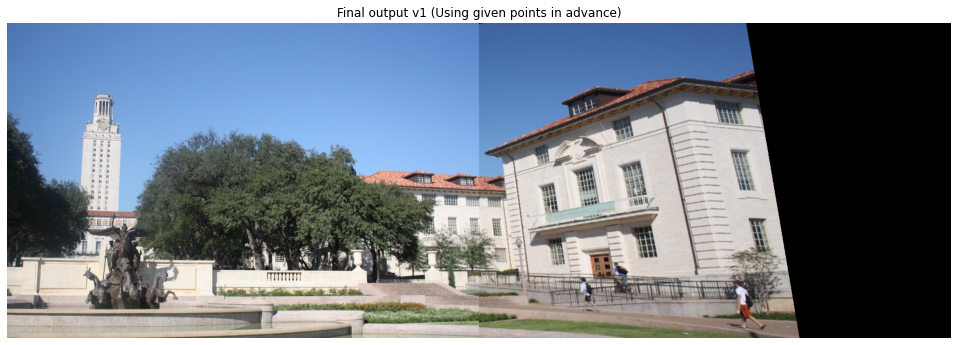

In [313]:
dst = warp(img2, H).astype(int)
dst[0:img1.shape[0], 0:img1.shape[1]] = img1
print_photo(dst, true_size = True, title = 'Final output v1 (Using given points in advance)')

# BONUS : Using descriptors to detect points

## Using ORB to find keypoints and descriptors

In [0]:
orb = cv2.ORB_create(nfeatures=3000, scoreType=cv2.ORB_FAST_SCORE)
kp1, des1 = orb.detectAndCompute(img1, None)
kp2, des2 = orb.detectAndCompute(img2, None)

## Visualizing key points' location

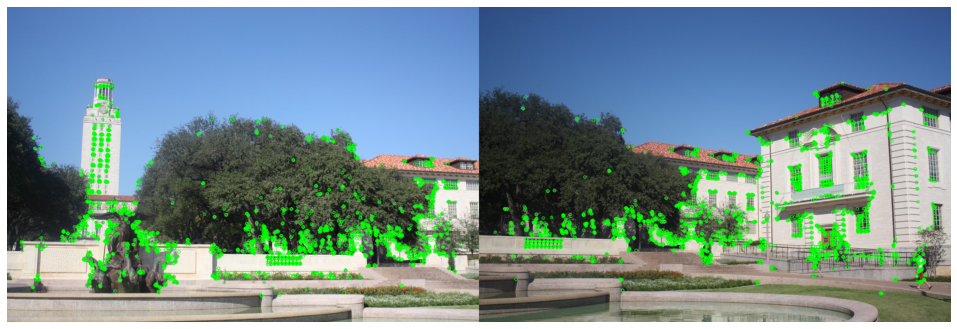

In [116]:
img_1, img_2 = img1, img2

# drawing only keypoints location,not size and orientation
img_1 = cv2.drawKeypoints(img1,kp1,np.array([]),color=(0,255,0), flags=0)
img_2 = cv2.drawKeypoints(img2,kp2,np.array([]),color=(0,255,0), flags=0)
both = np.concatenate((img_1, img_2), axis=1)
print_photo(both, true_size = True)

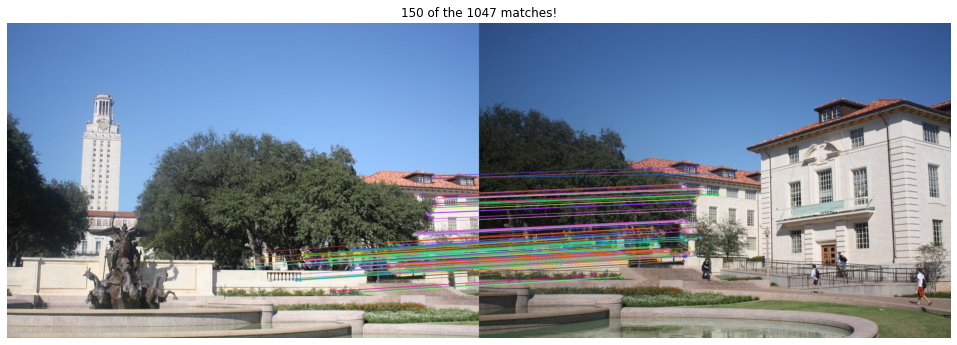

In [117]:
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck = True)
matches = bf.match(des1, des2)
matches = sorted(matches, key = lambda x:x.distance)
img3 = cv2.drawMatches(img1, kp1, img2, kp2, matches[:150] ,np.array([]), flags=2)
print_photo(img3, true_size = True, title = '150 of the {} matches!'.format(len(matches)))

# Using the best 70 matches to find Homography Matrix + Warping

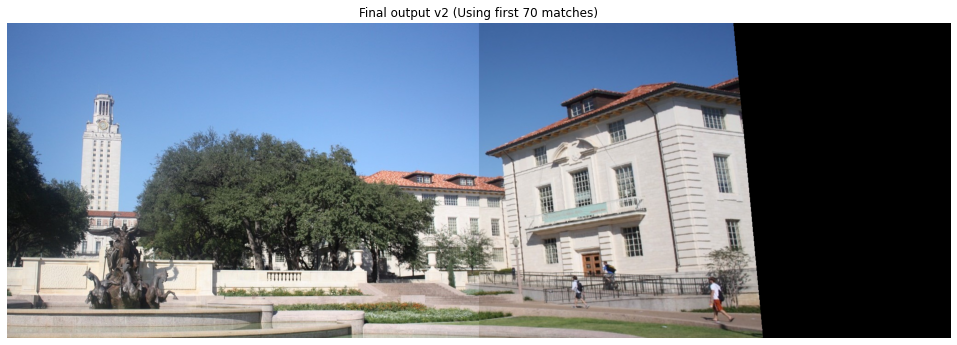

In [320]:
mx = 70
best1 = np.array([kp1[matches[i].queryIdx].pt for i in range(mx)])
best2 = np.array([kp2[matches[i].trainIdx].pt for i in range(mx)])

#Same code as above

#Heterogenous -> Homogenous
new_axis = np.ones((len(best1),1))
hom1 = np.append(best1, new_axis, axis = 1)
hom2 = np.append(best2, new_axis, axis = 1)

#Find Matrix A, where A * H = 0
no_pts = len(hom1)
P = np.zeros((2 * no_pts, 9))
for i in range(len(P)):
  curr_pt1, curr_pt2 = hom1[i//2], hom2[i//2]
  if i & 1 == 0:
    P[i] = np.append(np.append(curr_pt2 * -1, [0, 0, 0]), curr_pt2 * curr_pt1[0])
  else:
    P[i] = np.append(np.append([0, 0, 0], curr_pt2 * -1), curr_pt2 * curr_pt1[1])

#SVD
u, s, vh = np.linalg.svd(P)
H = (vh[-1:].T)/vh[-1:].T[8]
H = np.reshape(H, (3,3))

#Warp img2 + stitch img1
dst = warp(img2, H).astype(int)
dst[0:img1.shape[0], 0:img1.shape[1]] = img1
print_photo(dst, true_size = True, title = 'Final output v2 (Using first {} matches)'.format(mx))